# single-cell Progeny Production analysis
This notebook provides a central place to integrate and analyze transcriptome and progeny production data.

## Notebook setup
First give paths and values to all variables. Then, load in data.

Python imports:

In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import numpy

import pandas as pd

import plotnine as p9

import scanpy

import scipy

import statsmodels.stats.multitest

Input data paths. Currently hardcoded.

In [2]:
matrix = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/matrix.mtx'
cell_barcodes = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/barcodes.tsv'
features = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/features.tsv'
viral_tag_by_cell_csv = 'results/viral_tags_bcs_in_cells/scProgenyProduction_trial3_cell_barcodes_with_viral_tags.csv.gz'
viral_bc_background_freq_csv = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_background_freq.csv.gz'
viral_bc_in_progeny_freq_csv = 'results/viral_progeny/scProgenyProduction_trial3_viral_bc_in_progeny_freq.csv.gz'

Global variables for this notebook:

In [3]:
expt = 'scProgenyProduction_trial3'
plot = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_correlations.pdf'
viral_genes = ['fluPB2', 'fluPB1', 'fluPA', 'fluHA', 'fluNA', 'fluNP', 'fluM', 'fluNS']
barcoded_viral_genes = ['fluHA', 'fluNA']

Style parameters. *N.b.* `CBPALETTE` is defined in imports above.

In [4]:
p9.theme_set(p9.theme_classic())

### Load data

**Transcriptome** viral barcode frequencies:

In [5]:
transcriptome_viral_bc_freqs = pd.read_csv(viral_bc_background_freq_csv)
assert set(transcriptome_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
display(transcriptome_viral_bc_freqs)

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0,0.000000,False
1,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0,0.000000,False
2,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0,0.000000,False
3,AAACGAAGTACTTCCC,True,both,0.448272,fluHA,NaN,0,0.000000,False
4,AAACGAAGTAGACGTG,True,wt,0.040116,fluHA,AAGTAAGCGACATGAG,93,0.001731,True
...,...,...,...,...,...,...,...,...,...
9185,TTTGATCTCCCGTTCA,False,none,0.000109,fluNA,NaN,0,0.000000,False
9186,TTTGATCTCGCATTGA,True,wt,0.063156,fluNA,NaN,0,0.000000,False
9187,TTTGGAGAGTTGCCTA,False,none,0.000070,fluNA,NaN,0,0.000000,False
9188,TTTGGAGGTATCGTTG,True,wt,0.024534,fluNA,ACATCTTATTTACACG,15,0.000230,True


**Progeny** viral barcode frequencies:

*N.b. For now just work with supernatant data. Remove second_infection frequencies.*

In [6]:
progeny_viral_bc_freqs = pd.read_csv(viral_bc_in_progeny_freq_csv)
assert set(progeny_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
progeny_viral_bc_freqs = (progeny_viral_bc_freqs
                          .rename(columns={'barcode': 'viral_barcode',
                                           'tag': 'infecting_viral_tag',
                                           'mean_freq': 'freq_sup',
                                           'mean_count': 'count_sup'}))
progeny_viral_bc_freqs = (progeny_viral_bc_freqs
                          .query('source == "supernatant"'))
progeny_viral_bc_freqs = progeny_viral_bc_freqs.drop(columns = 'source')
display(progeny_viral_bc_freqs)

,infecting_viral_tag,gene,viral_barcode,count_sup,freq_sup
0,syn,fluHA,AAAAAAGCACGAGCAG,0.5,2.507618e-07
1,syn,fluHA,AAAAAATCCTTCAGCA,0.5,2.574453e-07
2,syn,fluHA,AAAAAATGGCGACGCT,0.5,2.574453e-07
3,syn,fluHA,AAAAAATTGGTTTACT,0.5,2.574453e-07
4,syn,fluHA,AAAAACACTCACAAGT,0.5,2.574453e-07
...,...,...,...,...,...
61196,wt,fluNA,TTTTTCCCTTACATAT,0.5,2.399886e-07
61197,wt,fluNA,TTTTTCTTACGATCAC,0.5,2.399886e-07
61198,wt,fluNA,TTTTTCTTCGAGATAG,6.0,3.062051e-06
61199,wt,fluNA,TTTTTGGGATCATTGC,2.0,1.142142e-06


Cell-gene matrix:

In [7]:
adata = scanpy.read_mtx(matrix)
adata.var = pd.read_csv(cell_barcodes,
                        names=['cell_barcode'])
adata.obs = pd.read_csv(features,
                        sep='\t',
                        names=['ensemble_id', 'gene', 'feature_type'])

print(f"Read cell-gene matrix of {adata.n_vars} cells and {adata.n_obs} genes")

assert set(viral_genes).issubset(set(adata.obs['gene'])), 'lack viral genes'

Read cell-gene matrix of 3368 cells and 30959 genes


### Cross-check data
Use assert statements to ensure that that the number and identity of cell barcodes is identical between data sources.

In [8]:
assert transcriptome_viral_bc_freqs['cell_barcode'].nunique() == \
       adata.var['cell_barcode'].nunique(), \
       "Number of cells discrepancy"

assert set(transcriptome_viral_bc_freqs['cell_barcode']) == \
       set(adata.var['cell_barcode']), \
       "Cell barcodes do not match between data sources"

### Plot raw data
Plot data from each source without filtering or processing. This is mostly for exploration and transparency.

#### Viral barcode transcription

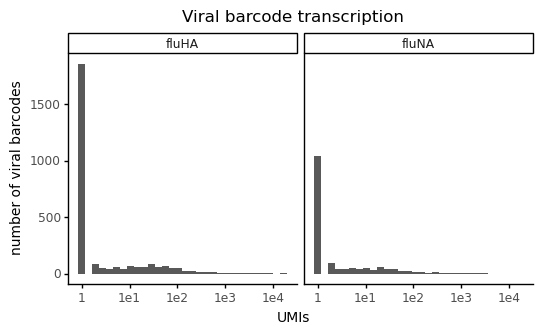

<ggplot: (8775496251778)>

In [9]:
fig = (p9.ggplot((transcriptome_viral_bc_freqs
                  .query('viral_barcode.notnull()',
                         engine='python')),
                 p9.aes(x='viral_bc_UMIs')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode transcription') +
       p9.labs(x='UMIs',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

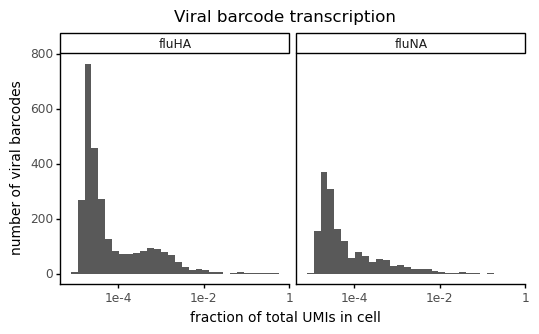

<ggplot: (8775496766600)>

In [10]:
fig = (p9.ggplot((transcriptome_viral_bc_freqs
                  .query('viral_barcode.notnull()',
                         engine='python')),
                 p9.aes(x='frac_viral_bc_UMIs')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode transcription') +
       p9.labs(x='fraction of total UMIs in cell',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

#### Progeny production: supernatant

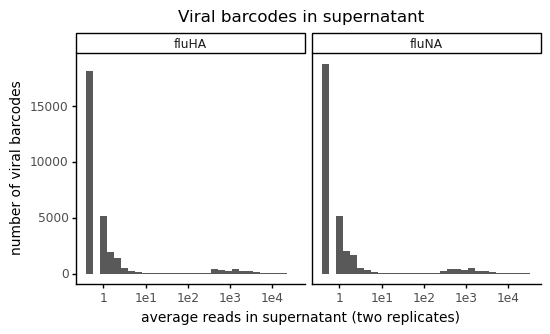

<ggplot: (8775495796038)>

In [11]:
fig = (p9.ggplot(progeny_viral_bc_freqs,
                 p9.aes(x='count_sup')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcodes in supernatant') +
       p9.labs(x='average reads in supernatant (two replicates)',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

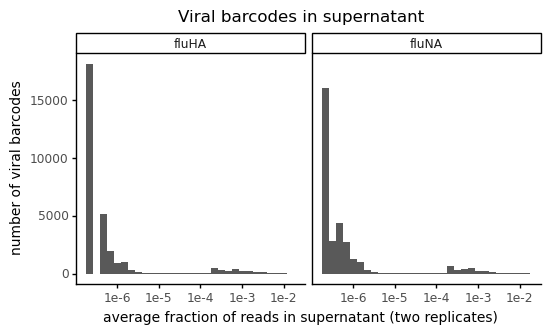

<ggplot: (8775495584684)>

In [12]:
fig = (p9.ggplot(progeny_viral_bc_freqs,
                 p9.aes(x='freq_sup')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcodes in supernatant') +
       p9.labs(x='average fraction of reads in supernatant (two replicates)',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

### Process data
Next, I will merge the data into a few useable dataframes. I will perform calculations on these data that will help us visualize technical error and filter.

#### Merge all viral barcode data into a central dataframe called `viral_bc_freqs`

Structure of the final dataframe should be as follows:
1. Cell barcode
2. Infected
3. Infecting viral tag
4. Gene
5. Viral barcode
6. Count in the transcriptome (`viral_bc_UMIs`)
7. Frequency in transcriptome (`frac_viral_bc_UMIs`)
8. Count in the supernatant sequencing (`count_sup`)
9. Frequency in supernatant sequencing (`freq_sup`)

In [13]:
viral_bc_freqs = pd.merge(
    left=transcriptome_viral_bc_freqs,
    right=progeny_viral_bc_freqs,
    how='outer',
    on=['viral_barcode', 'gene', 'infecting_viral_tag'])

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,count_sup,freq_sup
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,NaN,NaN
1,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,NaN,NaN
2,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,NaN,NaN
3,AAACGCTCAAATGATG,False,none,0.000107,fluHA,NaN,0.0,0.0,False,NaN,NaN
4,AAACGCTCATGGACAG,False,none,0.000119,fluHA,NaN,0.0,0.0,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
70011,NaN,NaN,wt,NaN,fluNA,TTTTTCCCTTACATAT,NaN,NaN,NaN,0.5,2.399886e-07
70012,NaN,NaN,wt,NaN,fluNA,TTTTTCTTACGATCAC,NaN,NaN,NaN,0.5,2.399886e-07
70013,NaN,NaN,wt,NaN,fluNA,TTTTTCTTCGAGATAG,NaN,NaN,NaN,6.0,3.062051e-06
70014,NaN,NaN,wt,NaN,fluNA,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,1.142142e-06


Fill `NA` values in supernatant with `0`. It is meaningful if a viral barcode is seen in the transcriptome but absent from the supernatant; no progeny was produced by that infected cell.

In [14]:
viral_bc_freqs[['count_sup', 'freq_sup']] = (
    viral_bc_freqs[['count_sup', 'freq_sup']]
    .fillna(0)
)

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,count_sup,freq_sup
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00
1,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00
2,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00
3,AAACGCTCAAATGATG,False,none,0.000107,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00
4,AAACGCTCATGGACAG,False,none,0.000119,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
70011,NaN,NaN,wt,NaN,fluNA,TTTTTCCCTTACATAT,NaN,NaN,NaN,0.5,2.399886e-07
70012,NaN,NaN,wt,NaN,fluNA,TTTTTCTTACGATCAC,NaN,NaN,NaN,0.5,2.399886e-07
70013,NaN,NaN,wt,NaN,fluNA,TTTTTCTTCGAGATAG,NaN,NaN,NaN,6.0,3.062051e-06
70014,NaN,NaN,wt,NaN,fluNA,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,1.142142e-06


Get total UMIs per cell. Get viral UMI counts and fractions per cell. Assert that these match what is already found in `viral_freqs`:

In [15]:
umi_counts = (
    adata.var
    .assign(total_UMIs=numpy.sum(adata.X, axis=0).A1.astype(int),
            viral_UMIs=numpy.sum(adata[adata.obs['gene']
                                       .isin(viral_genes), ].X,
                                 axis=0).A1.astype(int),
            )
    )

viral_bc_freqs = pd.merge(
    left=viral_bc_freqs,
    right=umi_counts,
    how='outer',
    on=['cell_barcode'])

test_viral_frac_UMIs = pd.Series(
    viral_bc_freqs['viral_UMIs'] / viral_bc_freqs['total_UMIs'],
    name='frac_viral_UMIs')

pd.testing.assert_series_equal(
    test_viral_frac_UMIs, viral_bc_freqs['frac_viral_UMIs'])

viral_bc_freqs

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,count_sup,freq_sup,total_UMIs,viral_UMIs
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,20969.0,1.0
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,0.0,0.000000e+00,20969.0,1.0
2,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,39505.0,2.0
3,AAACCCATCATTGCTT,False,none,0.000051,fluNA,NaN,0.0,0.0,False,0.0,0.000000e+00,39505.0,2.0
4,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,49137.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70011,NaN,NaN,wt,NaN,fluNA,TTTTTCCCTTACATAT,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN
70012,NaN,NaN,wt,NaN,fluNA,TTTTTCTTACGATCAC,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN
70013,NaN,NaN,wt,NaN,fluNA,TTTTTCTTCGAGATAG,NaN,NaN,NaN,6.0,3.062051e-06,NaN,NaN
70014,NaN,NaN,wt,NaN,fluNA,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,1.142142e-06,NaN,NaN


#### Raw correlation of viral transcription and progeny production
Plot raw data:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


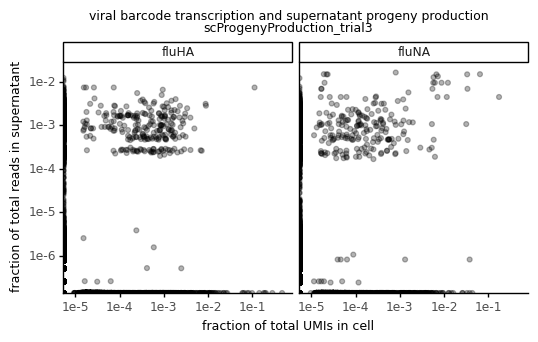

<ggplot: (8775495480570)>

In [16]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_sup')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle('viral barcode transcription and supernatant progeny production\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

#### Plot annotated by infection status

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


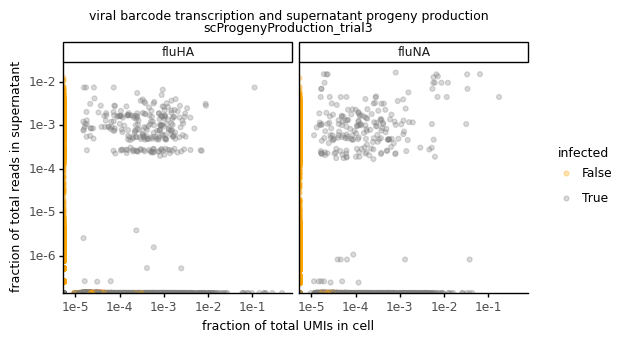

<ggplot: (8775495801140)>

In [17]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_sup',
                        color='infected')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle('viral barcode transcription and supernatant progeny production\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

#### Plot annotated by variant

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


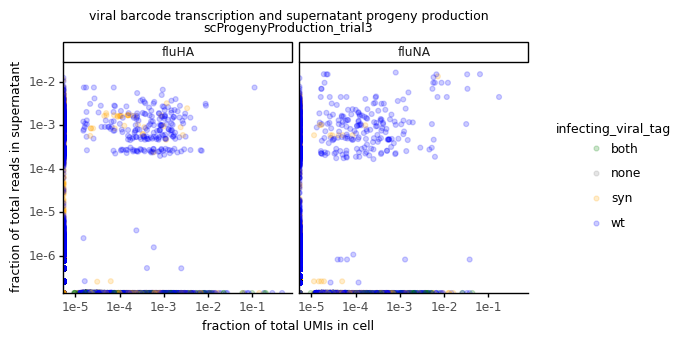

<ggplot: (8775495507694)>

In [18]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_sup',
                        color='infecting_viral_tag')) +
       p9.geom_point(alpha=0.2) +
       p9.facet_grid('~gene') +
       p9.ggtitle('viral barcode transcription and supernatant progeny production\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['green','grey','orange','blue']))
display(fig)

#### Significant viral barcodes found above background frequency in uninfected cells
During viral barcode processing from the transcriptome, the frequency of viral barcodes is calculated in uninfected cells. A poisson distribution is built around the expected number of UMIs for each cell-gene, and viral barcodes are called as significant if they reject the null hypothesis that they are pulled from this distribution.

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


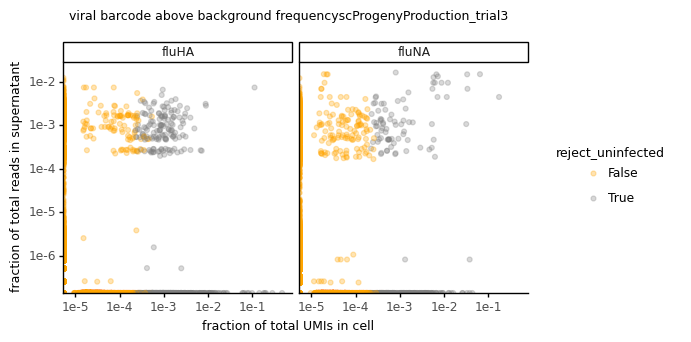

<ggplot: (8774832748915)>

In [19]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_sup',
                        color='reject_uninfected')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle('viral barcode above background frequency'
                  f'{expt}\n') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

#### Viral barcode sharing across cells
How often is a significant viral barcode found in more than one cell? This should be very unlikely in a low MOI infection.

In [20]:
n_cell_bc = (viral_bc_freqs
             .query('(reject_uninfected == True) and '
                    '(cell_barcode.notna())',
                    engine='python')
             .groupby(['infecting_viral_tag',
                       'gene',
                       'viral_barcode',
                       'reject_uninfected'])
             ['cell_barcode']
             .nunique()
             .reset_index()
             .rename(columns={'cell_barcode': 'n_cell_bc'}))

n_cell_bc

viral_bc_freqs = pd.merge(
    viral_bc_freqs,
    n_cell_bc,
    on=['infecting_viral_tag',
        'gene',
        'viral_barcode',
        'reject_uninfected'],
    how='left')

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,count_sup,freq_sup,total_UMIs,viral_UMIs,n_cell_bc
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,20969.0,1.0,NaN
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,0.0,0.000000e+00,20969.0,1.0,NaN
2,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,39505.0,2.0,NaN
3,AAACCCATCATTGCTT,False,none,0.000051,fluNA,NaN,0.0,0.0,False,0.0,0.000000e+00,39505.0,2.0,NaN
4,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,49137.0,10.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70011,NaN,NaN,wt,NaN,fluNA,TTTTTCCCTTACATAT,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN,NaN
70012,NaN,NaN,wt,NaN,fluNA,TTTTTCTTACGATCAC,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN,NaN
70013,NaN,NaN,wt,NaN,fluNA,TTTTTCTTCGAGATAG,NaN,NaN,NaN,6.0,3.062051e-06,NaN,NaN,NaN
70014,NaN,NaN,wt,NaN,fluNA,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,1.142142e-06,NaN,NaN,NaN


Plot distribution of cell barcode per viral barcode.

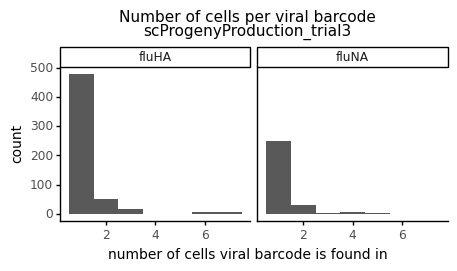

<ggplot: (8774819153999)>

In [21]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(reject_uninfected == True) and '
                        '(cell_barcode.notna())',
                        engine='python')) +
       p9.geom_histogram(p9.aes(x='n_cell_bc'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of cells per viral barcode\n'
                  f'{expt}') +
       p9.xlab('number of cells viral barcode is found in') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Now I will label viral barcodes that are found in more than 1 cells.

In [22]:
viral_bc_freqs['gt1_cell'] = (
    viral_bc_freqs['n_cell_bc'] > 1)

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,count_sup,freq_sup,total_UMIs,viral_UMIs,n_cell_bc,gt1_cell
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,20969.0,1.0,NaN,False
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,0.0,0.000000e+00,20969.0,1.0,NaN,False
2,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,39505.0,2.0,NaN,False
3,AAACCCATCATTGCTT,False,none,0.000051,fluNA,NaN,0.0,0.0,False,0.0,0.000000e+00,39505.0,2.0,NaN,False
4,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,49137.0,10.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70011,NaN,NaN,wt,NaN,fluNA,TTTTTCCCTTACATAT,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN,NaN,False
70012,NaN,NaN,wt,NaN,fluNA,TTTTTCTTACGATCAC,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN,NaN,False
70013,NaN,NaN,wt,NaN,fluNA,TTTTTCTTCGAGATAG,NaN,NaN,NaN,6.0,3.062051e-06,NaN,NaN,NaN,False
70014,NaN,NaN,wt,NaN,fluNA,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,1.142142e-06,NaN,NaN,NaN,False


Plot number of viral barcodes that were found in more than 1 cell:

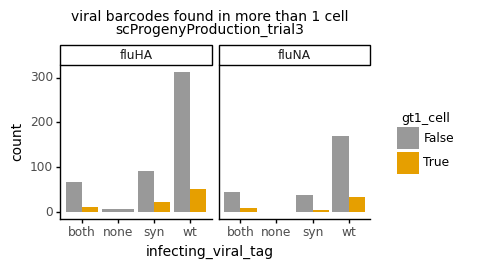

<ggplot: (8775495494126)>

In [23]:
fig = (p9.ggplot((viral_bc_freqs
                  .query('(reject_uninfected == True) and '
                         '(cell_barcode.notna())',
                         engine='python')),
                 p9.aes(x='infecting_viral_tag',
                        fill='gt1_cell')) +
       p9.geom_bar(stat='count', position='dodge') +
       p9.ggtitle('viral barcodes found in more than 1 cell\n'
                  f'{expt}') +
       p9.facet_grid('~gene') +
       p9.theme(figure_size=(4, 2),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

#### Plot annotated with significant viral barcodes found in more than one cell

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


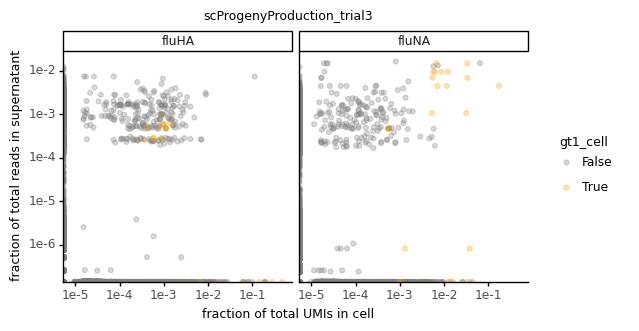

<ggplot: (8774818140097)>

In [24]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_sup',
                        color='gt1_cell')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

#### Viral barcodes per cell
Count the number of significant viral barcodes (above background) in each cell on each segment.

In [25]:
n_viral_bc = (viral_bc_freqs
             .query('(reject_uninfected == True) and '
                    '(cell_barcode.notna())',
                    engine='python')
             .groupby(['infecting_viral_tag',
                       'gene',
                       'cell_barcode',
                       'reject_uninfected'])
             ['viral_barcode']
             .nunique()
             .reset_index()
             .rename(columns={'viral_barcode': 'n_viral_bc'}))

viral_bc_freqs = pd.merge(
    viral_bc_freqs,
    n_viral_bc,
    on=['infecting_viral_tag',
        'gene',
        'cell_barcode',
        'reject_uninfected'],
    how='left')

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,count_sup,freq_sup,total_UMIs,viral_UMIs,n_cell_bc,gt1_cell,n_viral_bc
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN
2,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,39505.0,2.0,NaN,False,NaN
3,AAACCCATCATTGCTT,False,none,0.000051,fluNA,NaN,0.0,0.0,False,0.0,0.000000e+00,39505.0,2.0,NaN,False,NaN
4,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,49137.0,10.0,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70011,NaN,NaN,wt,NaN,fluNA,TTTTTCCCTTACATAT,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN,NaN,False,NaN
70012,NaN,NaN,wt,NaN,fluNA,TTTTTCTTACGATCAC,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN,NaN,False,NaN
70013,NaN,NaN,wt,NaN,fluNA,TTTTTCTTCGAGATAG,NaN,NaN,NaN,6.0,3.062051e-06,NaN,NaN,NaN,False,NaN
70014,NaN,NaN,wt,NaN,fluNA,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,1.142142e-06,NaN,NaN,NaN,False,NaN


Plot distribution of viral barcode per cell.

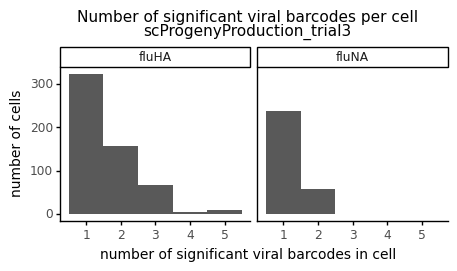

<ggplot: (8775495566391)>

In [26]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(reject_uninfected == True) and '
                        '(cell_barcode.notna())',
                        engine='python')) +
       p9.geom_histogram(p9.aes(x='n_viral_bc'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of significant viral barcodes per cell\n'
                  f'{expt}') +
       p9.xlab('number of significant viral barcodes in cell') +
       p9.ylab('number of cells') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Now I will label cells that have more than 1 viral barcode on a segment.

In [27]:
viral_bc_freqs['gt1_viral_bc'] = (
    viral_bc_freqs['n_viral_bc'] > 1)

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,count_sup,freq_sup,total_UMIs,viral_UMIs,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN,False
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN,False
2,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,39505.0,2.0,NaN,False,NaN,False
3,AAACCCATCATTGCTT,False,none,0.000051,fluNA,NaN,0.0,0.0,False,0.0,0.000000e+00,39505.0,2.0,NaN,False,NaN,False
4,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,49137.0,10.0,NaN,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70011,NaN,NaN,wt,NaN,fluNA,TTTTTCCCTTACATAT,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN,NaN,False,NaN,False
70012,NaN,NaN,wt,NaN,fluNA,TTTTTCTTACGATCAC,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN,NaN,False,NaN,False
70013,NaN,NaN,wt,NaN,fluNA,TTTTTCTTCGAGATAG,NaN,NaN,NaN,6.0,3.062051e-06,NaN,NaN,NaN,False,NaN,False
70014,NaN,NaN,wt,NaN,fluNA,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,1.142142e-06,NaN,NaN,NaN,False,NaN,False


Plot number of cells with more than 1 significant viral barcode

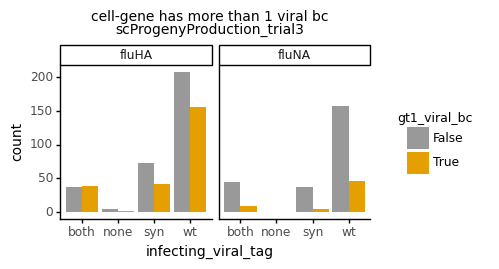

<ggplot: (8774818191598)>

In [28]:
fig = (p9.ggplot((viral_bc_freqs
                         .query('(reject_uninfected == True) and '
                                '(cell_barcode.notna())',
                                engine='python')),
                        p9.aes(x='infecting_viral_tag',
                               fill='gt1_viral_bc')) +
              p9.geom_bar(stat='count', position='dodge') +
              p9.ggtitle('cell-gene has more than 1 viral bc\n'
                         f'{expt}') +
              p9.facet_grid('~gene') +
              p9.theme(figure_size=(4, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

#### Plot annotated highlighting cells with more than 1 significant viral barcode

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


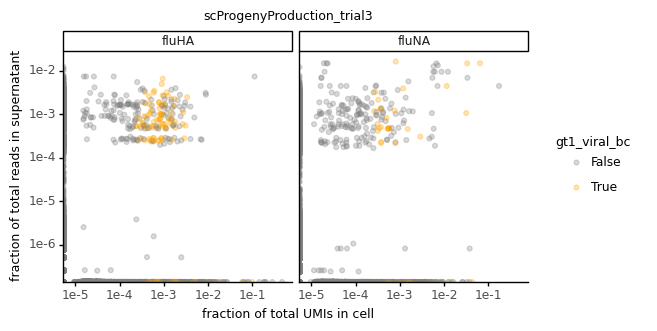

<ggplot: (8775496220892)>

In [29]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_sup',
                        color='gt1_viral_bc')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

#### Viral barcode rank in cell
I will rank each viral barcode in each cell-gene. I will see what fraction of all viral barcode UMIs each viral barcode accounts for.

To do this, I will:
* Group viral barcodes by cell-gene
* Sum fraction of cell UMIs that are assigned to **significant** viral barcodes in that cell-gene
* Rank only viral barcodes **that are significant above uninfected background**

Sum all **significant** viral bc freqs for each cell-gene:

In [30]:
viral_bc_freqs = (
    viral_bc_freqs
    .assign(
        cell_total_frac_viral_bc_UMIs=lambda x: x
                                                .query('reject_uninfected == True')
                                                .groupby(['cell_barcode',
                                                          'gene'])
                                                ['frac_viral_bc_UMIs']
                                                .transform('sum')))

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,count_sup,freq_sup,total_UMIs,viral_UMIs,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc,cell_total_frac_viral_bc_UMIs
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN,False,NaN
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN,False,NaN
2,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,39505.0,2.0,NaN,False,NaN,False,NaN
3,AAACCCATCATTGCTT,False,none,0.000051,fluNA,NaN,0.0,0.0,False,0.0,0.000000e+00,39505.0,2.0,NaN,False,NaN,False,NaN
4,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,49137.0,10.0,NaN,False,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70011,NaN,NaN,wt,NaN,fluNA,TTTTTCCCTTACATAT,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN,NaN,False,NaN,False,NaN
70012,NaN,NaN,wt,NaN,fluNA,TTTTTCTTACGATCAC,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN,NaN,False,NaN,False,NaN
70013,NaN,NaN,wt,NaN,fluNA,TTTTTCTTCGAGATAG,NaN,NaN,NaN,6.0,3.062051e-06,NaN,NaN,NaN,False,NaN,False,NaN
70014,NaN,NaN,wt,NaN,fluNA,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,1.142142e-06,NaN,NaN,NaN,False,NaN,False,NaN


Calculate proportion of total significant viral bc UMI fraction in cell-gene that is derived from each significant viral bc:

In [31]:
viral_bc_freqs = (
    viral_bc_freqs
    .assign(
        prop_cell_viral_bc_UMIs=lambda x: x['frac_viral_bc_UMIs'] /
                                          x['cell_total_frac_viral_bc_UMIs']))

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,count_sup,freq_sup,total_UMIs,viral_UMIs,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc,cell_total_frac_viral_bc_UMIs,prop_cell_viral_bc_UMIs
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN,False,NaN,NaN
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN,False,NaN,NaN
2,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,39505.0,2.0,NaN,False,NaN,False,NaN,NaN
3,AAACCCATCATTGCTT,False,none,0.000051,fluNA,NaN,0.0,0.0,False,0.0,0.000000e+00,39505.0,2.0,NaN,False,NaN,False,NaN,NaN
4,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,49137.0,10.0,NaN,False,NaN,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70011,NaN,NaN,wt,NaN,fluNA,TTTTTCCCTTACATAT,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN,NaN,False,NaN,False,NaN,NaN
70012,NaN,NaN,wt,NaN,fluNA,TTTTTCTTACGATCAC,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN,NaN,False,NaN,False,NaN,NaN
70013,NaN,NaN,wt,NaN,fluNA,TTTTTCTTCGAGATAG,NaN,NaN,NaN,6.0,3.062051e-06,NaN,NaN,NaN,False,NaN,False,NaN,NaN
70014,NaN,NaN,wt,NaN,fluNA,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,1.142142e-06,NaN,NaN,NaN,False,NaN,False,NaN,NaN


Rank significant viral barcodes within each cell-gene:

In [32]:
viral_bc_freqs = (
    viral_bc_freqs
    .assign(viral_bc_rank=lambda x: x.groupby(['cell_barcode', 'gene'])
                                     ['prop_cell_viral_bc_UMIs']
                                     .rank('dense', ascending=False)))

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,count_sup,freq_sup,total_UMIs,viral_UMIs,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc,cell_total_frac_viral_bc_UMIs,prop_cell_viral_bc_UMIs,viral_bc_rank
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN,False,NaN,NaN,NaN
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN,False,NaN,NaN,NaN
2,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,39505.0,2.0,NaN,False,NaN,False,NaN,NaN,NaN
3,AAACCCATCATTGCTT,False,none,0.000051,fluNA,NaN,0.0,0.0,False,0.0,0.000000e+00,39505.0,2.0,NaN,False,NaN,False,NaN,NaN,NaN
4,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,49137.0,10.0,NaN,False,NaN,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70011,NaN,NaN,wt,NaN,fluNA,TTTTTCCCTTACATAT,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN
70012,NaN,NaN,wt,NaN,fluNA,TTTTTCTTACGATCAC,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN
70013,NaN,NaN,wt,NaN,fluNA,TTTTTCTTCGAGATAG,NaN,NaN,NaN,6.0,3.062051e-06,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN
70014,NaN,NaN,wt,NaN,fluNA,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,1.142142e-06,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN


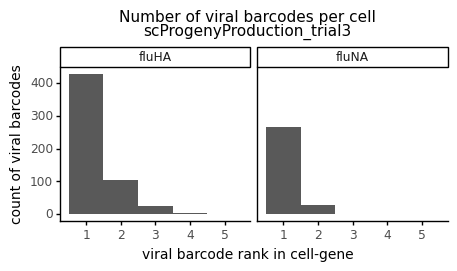

<ggplot: (8774817236164)>

In [33]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(reject_uninfected == True) and '
                        '(cell_barcode.notna())',
                        engine='python')) +
       p9.geom_histogram(p9.aes(x='viral_bc_rank'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of viral barcodes per cell\n'
                  f'{expt}') +
       p9.xlab('viral barcode rank in cell-gene') +
       p9.ylab('count of viral barcodes') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 69159 rows containing missing values.


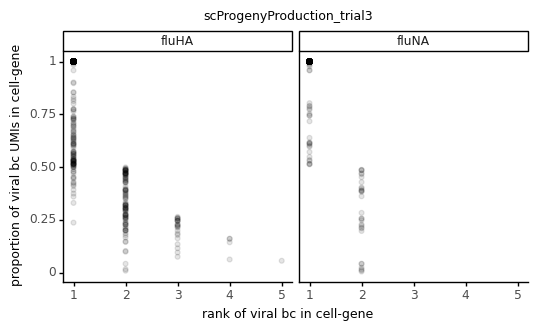

<ggplot: (8774817195533)>

In [34]:
fig = (p9.ggplot((viral_bc_freqs),
                 p9.aes(x='viral_bc_rank',
                        y='prop_cell_viral_bc_UMIs')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.labs(x='rank of viral bc in cell-gene',
               y='proportion of viral bc UMIs in cell-gene') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
      p9.scale_color_discrete(guide=False))
display(fig)

**Sanity check: viral rank vs number of viral barcodes per cell.**

The `n_significant_viral_bc_per_cell` histogram and `significant_viral_bc_rank_per_cell` histgoram do not look identical. I think some significant viral barcodes may be assigned duplicate ranks. I should check this and make sure it makes sense.

Result: Yes, sometimes low frequency viral barcodes in a cell have the same number of UMIs and get assigned identical ranks.

In [35]:
viral_bc_freqs.query('n_viral_bc > 3')

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,count_sup,freq_sup,total_UMIs,viral_UMIs,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc,cell_total_frac_viral_bc_UMIs,prop_cell_viral_bc_UMIs,viral_bc_rank
4441,ACAGAAATCTCTTGCG,True,wt,0.061243,fluHA,AAATATGAAACGATTT,81.0,0.002077,True,0.0,0.000000,38992.0,2388.0,1.0,False,5.0,True,0.008232,0.252336,3.0
4442,ACAGAAATCTCTTGCG,True,wt,0.061243,fluHA,AACTATCGGAGTAACA,106.0,0.002719,True,0.0,0.000000,38992.0,2388.0,1.0,False,5.0,True,0.008232,0.330218,1.0
4444,ACAGAAATCTCTTGCG,True,wt,0.061243,fluHA,GACCTTCTGAGAAAAC,18.0,0.000462,True,4953.0,0.002536,38992.0,2388.0,1.0,False,5.0,True,0.008232,0.056075,5.0
4446,ACAGAAATCTCTTGCG,True,wt,0.061243,fluHA,GTGAGACGTGACTTTC,20.0,0.000513,True,1027.5,0.000523,38992.0,2388.0,1.0,False,5.0,True,0.008232,0.062305,4.0
4448,ACAGAAATCTCTTGCG,True,wt,0.061243,fluHA,GTTTCTTCTTTTTTAG,96.0,0.002462,True,0.0,0.000000,38992.0,2388.0,1.0,False,5.0,True,0.008232,0.299065,2.0
5172,AACCAACGTCCAGTTA,True,wt,0.030916,fluHA,AATACCTCGCAGTAGT,30.0,0.000395,True,0.0,0.000000,75980.0,2349.0,2.0,True,5.0,True,0.001724,0.229008,2.0
5173,AACCAACGTCCAGTTA,True,wt,0.030916,fluHA,ACGGAAAATCATAAAT,28.0,0.000369,True,484.5,0.000250,75980.0,2349.0,2.0,True,5.0,True,0.001724,0.213740,3.0
5174,AACCAACGTCCAGTTA,True,wt,0.030916,fluHA,ACGCGCTCTAGCATTG,21.0,0.000276,True,0.0,0.000000,75980.0,2349.0,1.0,False,5.0,True,0.001724,0.160305,4.0
5176,AACCAACGTCCAGTTA,True,wt,0.030916,fluHA,CTCACTCATCCTTAAA,31.0,0.000408,True,0.0,0.000000,75980.0,2349.0,1.0,False,5.0,True,0.001724,0.236641,1.0
5177,AACCAACGTCCAGTTA,True,wt,0.030916,fluHA,TTTGCCAGAAAATCTT,21.0,0.000276,True,0.0,0.000000,75980.0,2349.0,1.0,False,5.0,True,0.001724,0.160305,4.0


#### Annotate most abundant viral barcode for each cell-gene:

In [36]:
viral_bc_freqs['top_viral_bc'] = (viral_bc_freqs['viral_bc_rank'] == 1)
viral_bc_freqs['top_viral_bc'].value_counts()

False    69321
True       695
Name: top_viral_bc, dtype: int64

#### Plot with most abundant viral barcode annotated:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


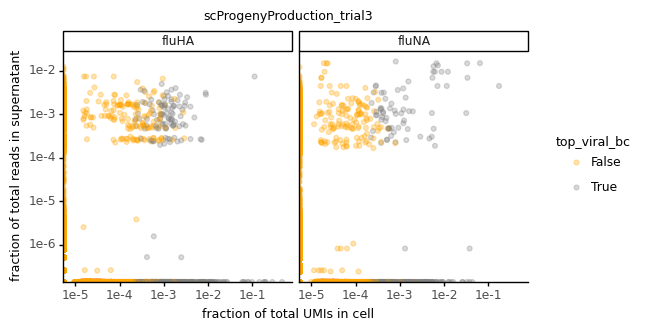

<ggplot: (8774816504453)>

In [37]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_sup',
                        color='top_viral_bc')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

#### Viral burden
Plot the viral burden (total fraction of viral UMIs in cell) against the supernatant frequency of the most abundant viral barcode for that cell.

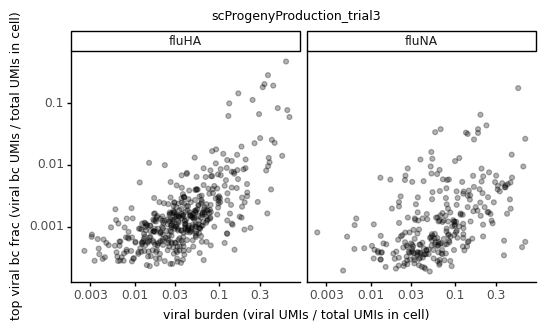

<ggplot: (8774816509706)>

In [38]:
fig = (p9.ggplot(viral_bc_freqs
                 .fillna(0)
                 .query('(infected == True) and'
                        '(top_viral_bc == True)'),
                 p9.aes(x='frac_viral_UMIs',
                        y='frac_viral_bc_UMIs')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell)',
               y='top viral bc frac (viral bc UMIs / total UMIs in cell)') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


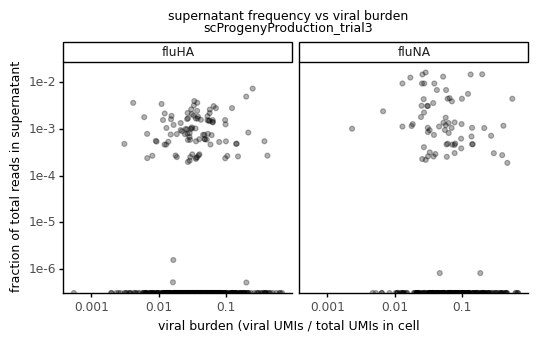

<ggplot: (8774819151882)>

In [39]:
fig = (p9.ggplot(viral_bc_freqs
                 .fillna(0)
                 .query('top_viral_bc == True',
                        engine='python'),
                 p9.aes(x='frac_viral_UMIs',
                        y='freq_sup')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'supernatant frequency vs viral burden\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

#### Correlation of fluHA and fluNA top viral barcodes in each cell
Check to see if cells associated with high fluHA also produce high fluNA values. 

First, pivot table so supernatant frequency of top fluHA viral barcode and top fluNA viral barcode are put in column alongside cell barcode. Fill NA values with zero because this means it was not observed in sequencing, so the frequency is meaningfully zero.

**Viral barcode transcription:**

In [40]:
high_transcription = (pd.pivot_table(
    viral_bc_freqs.query('top_viral_bc == True '),
    index=['cell_barcode',
           'infected',
           'infecting_viral_tag'],
    values='frac_viral_bc_UMIs',
    columns='gene')
                .reset_index()
                .fillna(0))

high_transcription

gene,cell_barcode,infected,infecting_viral_tag,fluHA,fluNA
0,AAACGAAGTACTTCCC,True,both,0.000000,0.005167
1,AAACGAAGTAGACGTG,True,wt,0.001731,0.000223
2,AAAGGATTCTGATGGT,True,syn,0.001017,0.007234
3,AAAGGGCCAGGCTACC,True,wt,0.001411,0.000000
4,AAAGGTAAGGAATGTT,True,wt,0.000274,0.000000
...,...,...,...,...,...
482,TTTAGTCGTGCTCCGA,True,wt,0.001559,0.000000
483,TTTCACAAGCCAAGCA,True,wt,0.004259,0.002974
484,TTTCGATTCAATCCAG,True,wt,0.000669,0.000000
485,TTTGATCTCGCATTGA,True,wt,0.001698,0.000000


Plot correlation:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


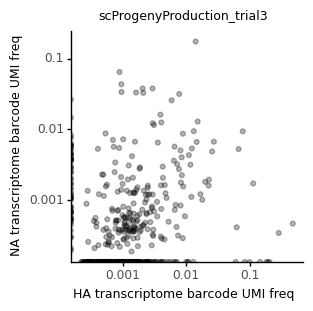

<ggplot: (8774816509709)>

In [41]:
fig = (p9.ggplot(high_transcription,
                 p9.aes(x='fluHA',
                        y='fluNA')) +
       p9.geom_point(alpha=0.3) +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='HA transcriptome barcode UMI freq',
               y='NA transcriptome barcode UMI freq') +
       p9.theme(figure_size=(3, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

**Supernatant progeny production:**

In [42]:
high_progeny = (pd.pivot_table(
    viral_bc_freqs.query('top_viral_bc == True '),
    index=['cell_barcode',
           'infected',
           'infecting_viral_tag'],
    values='freq_sup',
    columns='gene')
                .reset_index()
                .fillna(0))

high_progeny

gene,cell_barcode,infected,infecting_viral_tag,fluHA,fluNA
0,AAACGAAGTACTTCCC,True,both,0.000000,0.000000
1,AAACGAAGTAGACGTG,True,wt,0.000285,0.000289
2,AAAGGATTCTGATGGT,True,syn,0.000000,0.013190
3,AAAGGGCCAGGCTACC,True,wt,0.000000,0.000000
4,AAAGGTAAGGAATGTT,True,wt,0.000000,0.000000
...,...,...,...,...,...
482,TTTAGTCGTGCTCCGA,True,wt,0.000000,0.000000
483,TTTCACAAGCCAAGCA,True,wt,0.000000,0.000000
484,TTTCGATTCAATCCAG,True,wt,0.000534,0.000000
485,TTTGATCTCGCATTGA,True,wt,0.000000,0.000000


Plot correlation:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


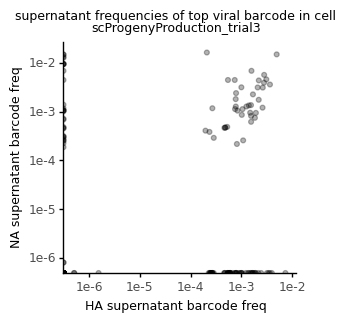

<ggplot: (8774832761158)>

In [43]:
fig = (p9.ggplot(high_progeny.
                 fillna(0),
                 p9.aes(x='fluHA',
                        y='fluNA')) +
       p9.geom_point(alpha=0.3) +
       p9.ggtitle('supernatant frequencies of top viral barcode in cell\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='HA supernatant barcode freq',
               y='NA supernatant barcode freq') +
       p9.theme(figure_size=(3, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

In [44]:
#### Viral genes in each cell